In [2]:
import torch
from torchvision.transforms import v2
import os
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from pathlib import Path

import helpers

In [6]:
helpers.create_h5_from_images("data/validation_truth.csv", "data/validation", "data/validation.h5", (128, 128))
helpers.create_h5_from_images("data/train_truth_1.csv", "data/train", "data/train.h5", (128, 128))
helpers.create_h5_from_images("data/test_truth_1.csv", "data/test", "data/test.h5", (128, 128))

Created data/validation.h5 with 150 samples.
Created data/train.h5 with 2000 samples.
Created data/test.h5 with 600 samples.


In [3]:
new_size = (int(3008/16), int(2000/16))
new_size_crop = (int(3008/16)-30, int(2000/16)-30)
old_size = (3008, 2000)
NEITHER = 0
SEB = 1
MELANOMA = 2

In [4]:
def show_transform(old, new, title=None):
    # Show the original and transformed images
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(old)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].imshow(new.permute(1, 2, 0).numpy())
    ax[1].set_title("Transformed Image")
    ax[1].axis("off")
    plt.tight_layout()
    plt.suptitle(title, fontsize=8)
    plt.show()

transform_crop = v2.Compose([
    v2.ToImage(),
    v2.RandomCrop(size=new_size_crop), 
    v2.RandomRotation(degrees=10),  # Random rotation
    #Flip the image horizontally with a 50% chance
    v2.ToDtype(torch.float32, scale=True),
])
transform_flip_h = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    v2.ToDtype(torch.float32, scale=True),
])
transform_flip_v = v2.Compose([
    v2.ToImage(),
    v2.RandomVerticalFlip(p=0.5),  # Vertical flip with 50% probability
    v2.ToDtype(torch.float32, scale=True),
])

#Colour randomization
transform_colour = v2.Compose([
    v2.ToImage(),
    v2.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.05),
    v2.ToDtype(torch.float32, scale=True),
])
#Transformation of "photo parameters"
transform_photo = v2.Compose([
    v2.ToImage(),
    v2.RandomAdjustSharpness(sharpness_factor=2.0),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.05, 1)),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianNoise(mean=0.0, sigma=0.02),
    
])
#Normalization
normalize = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    v2.ToTensor(),
    v2.ToImage(),
])

c:\Users\Simon\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [5]:
test_truth = pd.read_csv(r"data\test_truth.csv")
train_truth = pd.read_csv(r"data\train_truth.csv")
validation_truth = pd.read_csv(r"data\validation_truth.csv")

#Combine the dataframes
combined = pd.concat([train_truth, test_truth, validation_truth], ignore_index=True)

combined["truth"] = NEITHER
combined.loc[combined["melanoma"] == 1, "truth"] = MELANOMA
combined.loc[combined["seborrheic_keratosis"] == 1, "truth"] = SEB

combined.to_csv(r"data\combined_truth.csv", index=False)

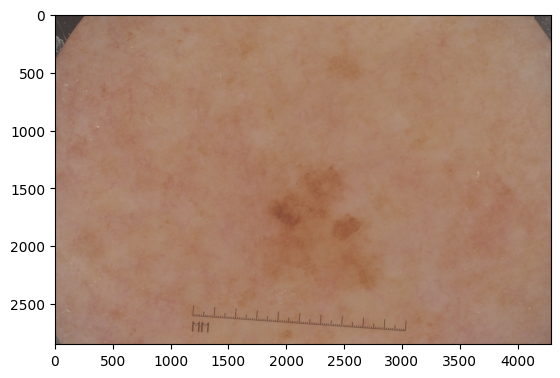

In [6]:
#Test image path
image = r"data\test\ISIC_0016072.jpg"
orig_img = PIL.Image.open(Path(image))
#Show original image
plt.imshow(orig_img)

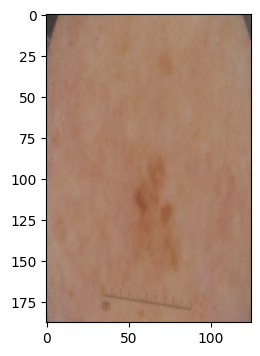

In [7]:
#Resize the image
resize = v2.Resize(new_size)
resized_img = resize(orig_img)

#Show the resized image
plt.figure(figsize=(6, 4))
plt.imshow(resized_img)

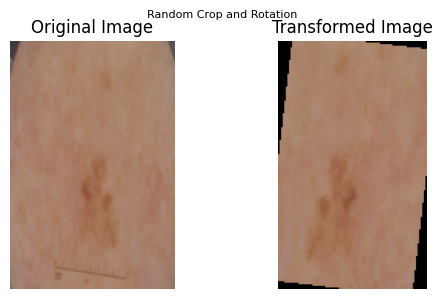

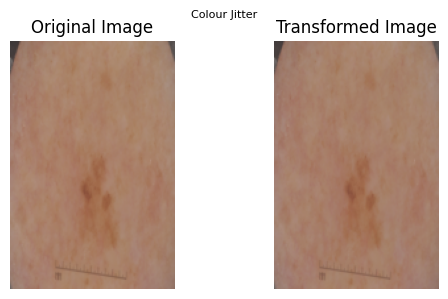

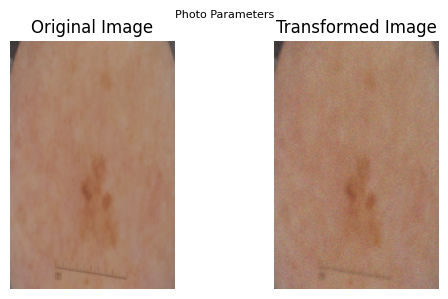

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5607843..0.39607847].


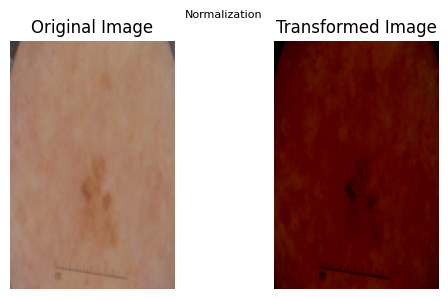

In [8]:

#Transformations
crop = transform_crop(resized_img)
crop = transform_flip_h(crop)
crop = transform_flip_v(crop)
show_transform(resized_img, crop, "Random Crop and Rotation")
colour = transform_colour(resized_img)
show_transform(resized_img, colour, "Colour Jitter")
photo = transform_photo(resized_img)
show_transform(resized_img, photo, "Photo Parameters")
norm = normalize(resized_img)
show_transform(resized_img, norm, "Normalization")

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = -5 * x + 0.1 * torch.randn(x.size())

model = torch.nn.Linear(1, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

def train_model(iter):
    for epoch in range(iter):
        y1 = model(x)
        loss = criterion(y1, y)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_model(10)
writer.flush()

In [2]:
writer.close()